In [1]:
import h5py
import warnings

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Load Dataset

In [2]:
with h5py.File('input/data/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])

with h5py.File('input/data/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

with h5py.File('input/data/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])

with h5py.File('input/data/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [3]:
data_train.shape

(30000, 784)

In [4]:
label_train.shape

(30000,)

In [5]:
data_test.shape

(10000, 784)

In [6]:
label_test.shape

(2000,)

## 2. Data Preprocessing

In this section, it contains two modules, one is splitting datasets into training and validation datasets, and the other is utilizing PCA to reduce dimension.

### 2.1 training, validation datasets split

In [7]:
"""
Splitting dataset into training and validation these two datasets.

Parameters:
    X - The original dataset
    y - The labels of dataset
    valid_ratio - The percentage of validation dataset, the value should be in (0, 1).
"""
def train_validate_split(X, y, valid_ratio):
    if (valid_ratio > 1) or (valid_ratio < 0):
        raise ValueError("The ratio of validation dataset must be between 0 and 1.")
    
    shuffled_idx = np.random.permutation(len(data_train))
    
    train_len = int(len(shuffled_idx) * (1- valid_ratio))
    
    train_idx = shuffled_idx[:train_len]
    valid_idx = shuffled_idx[train_len:]
    
    return X[train_idx], X[valid_idx], y[train_idx], y[valid_idx]  

In [8]:
X_train, X_valid, y_train, y_valid = train_validate_split(data_train, label_train, 0.2)

X_test = data_test[:2000]
y_test = label_test

print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)

print("X_valid.shape", X_valid.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (24000, 784)
y_train.shape (24000,)
X_valid.shape (6000, 784)
y_valid.shape (6000,)


### 2.2 Dimension Reduction - PCA

In [9]:
from PCA import PCA

"""
Create PCA class directly.

Parameters:
    n_components - The dimention after applying PCA.
"""
pca = PCA(n_components=100)
pca.fit(X_train)

PCA(n_components = 100)

In [10]:
X_train_reduction = pca.transform(X_train)
X_train_reduction.shape

(24000, 100)

In [11]:
X_valid_reduction = pca.transform(X_valid)
X_valid_reduction.shape

(6000, 100)

In [12]:
X_test_reduction = pca.transform(X_test)
X_test_reduction.shape

(2000, 100)

In [13]:
X_train_reduction_inv = pca.inverse_transform(X_train_reduction)
X_train_reduction_inv.shape

(24000, 784)

In [14]:
"""
Recover matrix to check, how much information is kept.

Parameters:
    X - The original dataset
    X_inv - The recovered PCA-applied dataset.
"""
def calc_similarity(X, X_inv):
    return 1 - np.sum((X-X_inv)**2) / np.sum(X**2)

In [15]:
calc_similarity(X_train, X_train_reduction_inv)

0.9627080435431079

## 3. Model

In this section, KNeighborsClassifier would be applied to classify the datasets.

In [16]:
%%time

from KNeighborsClassifier import KNeighborsClassifier

# Parameter "n_neighbors=5" by default.
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)

CPU times: user 992 µs, sys: 1.74 ms, total: 2.73 ms
Wall time: 3.1 ms


KNeighborsClassifier(n_neighbors=5)

In [17]:
%%time
y_pred_valid = knn_clf.predict(X_valid_reduction)
y_pred_valid.shape

CPU times: user 18min 54s, sys: 4.61 s, total: 18min 59s
Wall time: 19min 10s


(6000,)

In [18]:
%%time
y_pred_test = knn_clf.predict(X_test_reduction)
y_pred_test.shape

CPU times: user 6min 23s, sys: 2.17 s, total: 6min 25s
Wall time: 6min 31s


(2000,)

## 4. Metrics

In this section, it will show the performance of model through accuracy, confusion matrix, precision, recall and F1 score.

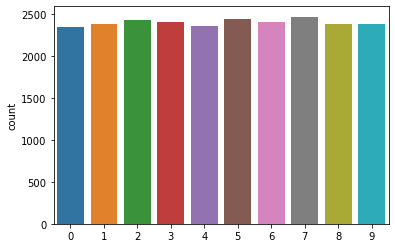

In [19]:
sns.countplot(x = y_train)
plt.show()

### 4.1 accuracy_score

In [20]:
from metrics import accuracy_score

accuracy_score_valid = accuracy_score(y_valid, y_pred_valid)
accuracy_score_valid

0.8488333333333333

In [21]:
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_test

0.8485

### 4.2 confusion_matrix

In [22]:
from metrics import confusion_matrix

def plot_confusion_matrix(data, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 5))

    ax = sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Confusion Matrix - " + title, fontsize="14")
    plt.xlabel("Actual", fontsize="12")
    plt.ylabel("Predict", fontsize="12")
    plt.show()

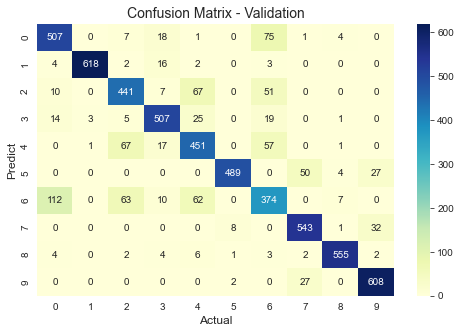

In [23]:
# Validation dataset
cm_valid = confusion_matrix(y_valid, y_pred_valid)
plot_confusion_matrix(cm_valid, "Validation")

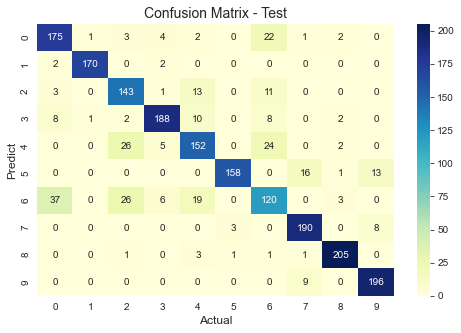

In [24]:
# Test dataset
cm_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_test, "Test")

#### 4.1.1 precision

In [25]:
from metrics import precision

precision = precision(y_test, y_pred_test)
precision

col_0
0    0.777778
1    0.988372
2    0.711443
3    0.912621
4    0.763819
5    0.975309
6    0.645161
7    0.875576
8    0.953488
9    0.903226
dtype: float64

#### 4.1.2 recall

In [26]:
from metrics import recall

recall = recall(y_test, y_pred_test)
recall

row_0
0    0.833333
1    0.977011
2    0.836257
3    0.858447
4    0.727273
5    0.840426
6    0.568720
7    0.945274
8    0.966981
9    0.956098
dtype: float64

#### 4.1.3 F1 score

In [27]:
from metrics import f1_score

f1_score = f1_score(y_test, y_pred_test)
f1_score

col_0
0    0.804598
1    0.982659
2    0.768817
3    0.884706
4    0.745098
5    0.902857
6    0.604534
7    0.909091
8    0.960187
9    0.928910
dtype: float64